In [12]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# **ACB**

In [13]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 8:2
df = pd.read_csv('DATASET/ACB Historical Data.csv')


In [14]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [15]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [16]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17628.227, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17631.234, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17632.354, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17632.436, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17629.663, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17629.313, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17629.285, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17632.729, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17632.611, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17627.219, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17631.425, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17630.969, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17625.661, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17630.888, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [17]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [18]:
# 5. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[18685.25913612 18699.27829731 18685.94550473 18698.62553283
 18686.5663103  18698.03512148 18687.12781551 18697.50110719
 18687.63568483 18697.01810281 18688.09504165 18696.58123579
 18688.51051995 18696.18609902 18688.8863111  18695.82870636
 18689.22620606 18695.50545242 18689.5336337  18695.21307623
 18689.81169535 18694.94862829 18690.0631961  18694.70944085
 18690.29067309 18694.49310098 18690.4964211  18694.29742624
 18690.68251574 18694.12044268]


In [21]:
# 6. Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  18.106390708943245
RMSE:  4467.495641093823
MDA:  41.52823920265781


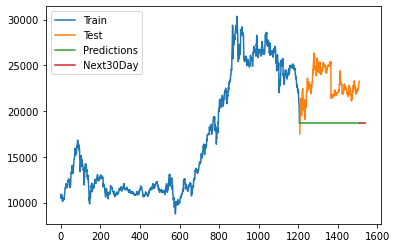

In [22]:
# 7.Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()

# **PVS**

In [23]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 8:2
df = pd.read_csv('DATASET/PVS Historical Data.csv')

In [24]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)


In [25]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


In [26]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=19348.420, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19345.714, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=19347.590, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=19347.587, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=19343.764, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=19345.113, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.006 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [27]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))


In [28]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800.
 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800.
 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800. 22800.]


In [31]:
# Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  21.769424908510963
RMSE:  9258.591585755103
MDA:  8.940397350993377


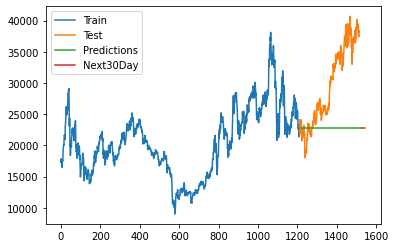

In [32]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()


# **VNM**

In [33]:
# Đọc file dữ liệu chứng khoán AAPL và chia train test theo tỉ lệ 8:2
df = pd.read_csv('DATASET/VNM Historical Data.csv')

In [34]:
# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

In [35]:
df = df[['Price']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.8 * len(df))
test_size = int(0.2 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]

In [36]:
# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21674.010, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21693.101, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21688.236, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21688.112, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21692.968, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21685.850, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21685.052, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=21675.618, Time=0.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21676.202, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21689.315, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=21683.391, Time=0.26 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=21680.608, Time=0.43 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21669.211, Time=1.10 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=21669.128, Time=1.24 sec
 ARIMA(4,1,2)(0,0,0

ARIMA(order=(4, 1, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [39]:
# Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

In [40]:
# Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[69266.02029986 69356.26497244 69291.51317109 69299.28986907
 69239.69351603 69278.24715369 69255.24998116 69296.12263648
 69267.76948481 69292.19742648 69262.85557188 69285.61772784
 69264.05867652 69286.13127534 69267.4833054  69285.37010197
 69268.20902624 69283.4595567  69268.94316735 69282.54032921
 69270.13841081 69281.83491638 69270.95956508 69280.99946697
 69271.5918547  69280.32683868 69272.22164441 69279.78787349
 69272.76021993 69279.29377948]


In [41]:
# Đánh giá độ chính xác test

test_ape = np.abs((y_test - y_pred) / y_test)
test_mape = np.mean(test_ape) * 100
print('MAPE: ', test_mape)

test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
print('RMSE: ', test_rmse)

# Hàm tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

test_mda = calculate_mda(y_test, y_pred)
print('MDA: ', test_mda)

MAPE:  6.749635397441835
RMSE:  6164.570338408621
MDA:  47.176079734219265


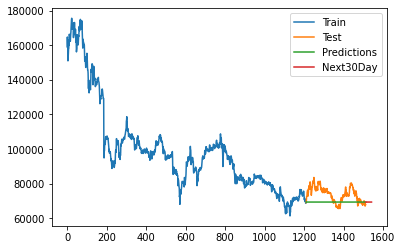

In [42]:
# Vẽ hình
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next30Day'])
plt.show()